In [12]:
import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

# 1. 讀 CSV
df = pd.read_csv('D:\\heatwave_event_synchronize_study\\data\\Hierarchical clustering\\分群篩選後資料\\post\\transactions_cluster_95threshold_post30y_cluster8.csv')

# 把字串轉回 list
transactions = df['transaction'].apply(ast.literal_eval).tolist()

# -----------------------------
# 轉成 one-hot 編碼並做 FP-Growth
# -----------------------------
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

min_support = 0.06  # 可依需求調整
# min_support = 0.05  # 可依需求調整
freq_items = fpgrowth(df_te, min_support=min_support, use_colnames=True)

print(freq_items)

     support                                          itemsets
0   0.186813                                   (27.625_82.375)
1   0.175824                                   (27.625_72.375)
2   0.131868                                   (27.625_67.375)
3   0.120879                                    (22.625_7.375)
4   0.109890                                 (22.625_-102.625)
..       ...                                               ...
56  0.076923                    (27.625_82.375, 22.625_57.375)
57  0.098901                  (67.625_167.375, 67.625_172.375)
58  0.087912                  (67.625_167.375, 72.625_162.375)
59  0.065934                  (72.625_107.375, 67.625_167.375)
60  0.087912  (67.625_167.375, 72.625_162.375, 67.625_172.375)

[61 rows x 2 columns]


In [13]:
# 6. 轉回經緯度 (DataFrame 展開)
def parse_latlon(item):
    lat, lon = item.split("_")
    return float(lat), float(lon)

records = []
for _, row in freq_items.iterrows():
    itemset = list(row['itemsets'])
    coords = [parse_latlon(item) for item in itemset]
    records.append({
        "itemset": itemset,
        "latitudes": [lat for lat, _ in coords],
        "longitudes": [lon for _, lon in coords],
        "support": row['support']
    })

frequent_itemsets_with_coords = pd.DataFrame(records)

# 7. 儲存結果
# frequent_itemsets_with_coords.to_csv("D:\\es\\frequent_itemset\\frequent_itemsets_95threshold_pre30y.csv", index=False)

print("✅ frequent itemsets 已轉換成經緯度並存檔")
print(frequent_itemsets_with_coords.head())
print('總筆數：', len(frequent_itemsets_with_coords))

✅ frequent itemsets 已轉換成經緯度並存檔
             itemset latitudes  longitudes   support
0    [27.625_82.375]  [27.625]    [82.375]  0.186813
1    [27.625_72.375]  [27.625]    [72.375]  0.175824
2    [27.625_67.375]  [27.625]    [67.375]  0.131868
3     [22.625_7.375]  [22.625]     [7.375]  0.120879
4  [22.625_-102.625]  [22.625]  [-102.625]  0.109890
總筆數： 61


In [14]:
from mlxtend.frequent_patterns import association_rules

# -----------------------
# 4️⃣ 生成關聯規則
# -----------------------
rules = association_rules(freq_items, metric="confidence", min_threshold=0.5)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
print('總筆數：', len(rules))
# rules.to_csv('D:\\es\\frequent_itemset\\association_rules_full_post30y.csv', index=False)

                         antecedents                       consequents  \
0                    (27.625_67.375)                   (27.625_72.375)   
1                    (27.625_72.375)                   (27.625_67.375)   
2                     (22.625_7.375)                   (22.625_12.375)   
3                    (22.625_12.375)                    (22.625_7.375)   
4                    (27.625_77.375)                   (27.625_82.375)   
5                    (22.625_17.375)                   (22.625_12.375)   
6                    (22.625_12.375)                   (22.625_17.375)   
7                    (22.625_17.375)                    (22.625_7.375)   
8                     (22.625_7.375)                   (22.625_17.375)   
9      (22.625_17.375, 22.625_7.375)                   (22.625_12.375)   
10    (22.625_17.375, 22.625_12.375)                    (22.625_7.375)   
11     (22.625_7.375, 22.625_12.375)                   (22.625_17.375)   
12                   (22.625_17.375)  

In [1]:
import pandas as pd
import glob
import os

# 指定資料夾路徑
folder_path = 'D:\\heatwave_event_synchronize_study\\data\\frequent_itemset\\pre\\'

# 找出該資料夾下所有 CSV 檔案
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# 逐一讀入並合併
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df['source_file'] = os.path.basename(file)  # 可記錄來源檔名，方便追蹤
    dfs.append(df)

# 合併成一個 DataFrame
rules = pd.concat(dfs, ignore_index=True)

print(f"共讀入 {len(csv_files)} 個檔案，總筆數 {len(rules)} 筆")

共讀入 3 個檔案，總筆數 11788052 筆


In [4]:
import pandas as pd
from ast import literal_eval

def frozenset_str_to_set(s):
    try:
        # 去掉外層 "frozenset(" 與 ")"，剩下 "{...}"
        if s.startswith("frozenset(") and s.endswith(")"):
            s_clean = s[len("frozenset("):-1]
        else:
            s_clean = s
        # literal_eval 解析成 set
        return set(literal_eval(s_clean))
    except Exception:
        return set()  # 出錯就回傳空集合

# 轉換
rules['antecedents'] = rules['antecedents'].apply(frozenset_str_to_set)
rules['consequents'] = rules['consequents'].apply(frozenset_str_to_set)

# 再計算中心
import numpy as np
from tqdm import tqdm

def compute_center_with_progress(sets_series):
    centers = []
    for coords_set in tqdm(sets_series, total=len(sets_series), desc="Computing centers"):
        if not coords_set:
            centers.append((np.nan, np.nan))
            continue
        coords_list = []
        for i in coords_set:
            try:
                lat, lon = map(float, i.split('_'))
                coords_list.append((lat, lon))
            except Exception:
                continue
        if len(coords_list) == 0:
            centers.append((np.nan, np.nan))
        else:
            coords_array = np.array(coords_list)
            lat_mean = np.mean(coords_array[:, 0])
            lon_mean = np.mean(coords_array[:, 1])
            centers.append((lat_mean, lon_mean))
    return zip(*centers)

rules['ante_lat'], rules['ante_lon'] = compute_center_with_progress(rules['antecedents'])
rules['cons_lat'], rules['cons_lon'] = compute_center_with_progress(rules['consequents'])

Computing centers: 100%|██████████| 60/60 [00:00<?, ?it/s]


In [15]:
import numpy as np
from tqdm import tqdm

# 假設 rules['antecedents'] 和 rules['consequents'] 是 set of "lat_lon" 字串

def compute_center_with_progress(sets_series):
    centers = []
    for coords_set in tqdm(sets_series, total=len(sets_series), desc="Computing centers"):
        if not coords_set:
            centers.append((np.nan, np.nan))
            continue
        coords_array = np.array([list(map(float, i.split('_'))) for i in coords_set])
        lat_mean = np.mean(coords_array[:, 0])
        lon_mean = np.mean(coords_array[:, 1])
        centers.append((lat_mean, lon_mean))
    return zip(*centers)

# 計算 antecedents 中心
rules['ante_lat'], rules['ante_lon'] = compute_center_with_progress(rules['antecedents'])

# 計算 consequents 中心
rules['cons_lat'], rules['cons_lon'] = compute_center_with_progress(rules['consequents'])

Computing centers: 100%|██████████| 60/60 [00:00<?, ?it/s]


In [16]:
from tqdm import tqdm

# 確保 tqdm 可以和 pandas 互動
tqdm.pandas(desc="Parsing antecedent coords")
rules['ante_coords'] = rules['antecedents'].progress_apply(
    lambda coord_set: [tuple(map(float, s.split('_'))) for s in coord_set]
)

tqdm.pandas(desc="Parsing consequent coords")
rules['cons_coords'] = rules['consequents'].progress_apply(
    lambda coord_set: [tuple(map(float, s.split('_'))) for s in coord_set]
)

Parsing consequent coords: 100%|██████████| 60/60 [00:00<?, ?it/s]


In [16]:
# 中心點
target_lat = 37.625
target_lon = 17.375
range_deg = 20  # ±5度

# 定義範圍
lat_range = (target_lat - range_deg, target_lat + range_deg)
lon_range = (target_lon - range_deg, target_lon + range_deg)

# 定義函數：只要 ante_coords 中有一個點落在 ±5 度內，就算符合
def in_latlon_range(coord_list):
    return any(
        lat_range[0] <= lat <= lat_range[1] and lon_range[0] <= lon <= lon_range[1]
        for lat, lon in coord_list
    )

# 篩選規則
nearby_rules = rules[rules['ante_coords'].apply(in_latlon_range)]

In [6]:
# 你關注的經緯度列表
target_coords = [
    # (27.625, 82.375),
    # (72.625, -107.625),
    # (52.625, 77.375),
    # (52.625, 27.375)
    # (77.625, 77.375),

    (57.625, -122.625),
]

target_set = set(target_coords)  # 為了加快查找效率

# 定義函數：只要 ante_coords 中有一個在 target_set 就算符合
def contains_target(coord_list):
    return any((lat, lon) in target_set for lat, lon in coord_list)

# 篩選 ante_coords 中包含目標經緯度的規則
nearby_rules = rules[rules['ante_coords'].apply(contains_target)]

In [ ]:
print(f"找到 {len(nearby_rules)} 條規則，antecedents 中心在緯度約 50、經度約 60 的範圍內：")
print(nearby_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

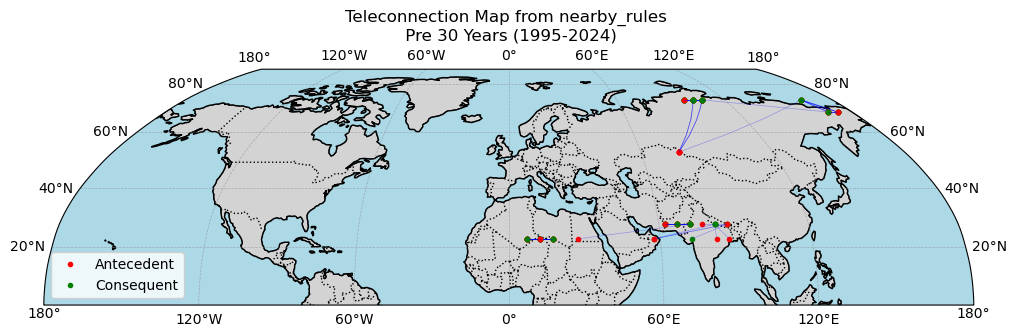

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# 1. 創建地圖
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# 標籤控制
ante_plotted = False
cons_plotted = False

# 2. 迭代 nearby_rules 繪圖
for idx, row in rules.iterrows():
    ante_coords = row['ante_coords']
    cons_coords = row['cons_coords']
    
    if isinstance(ante_coords, list) and isinstance(cons_coords, list):
        for (lat1, lon1) in ante_coords:
            # 標記前事件座標
            label = 'Antecedent' if not ante_plotted else None
            ax.plot(lon1, lat1, 'ro', markersize=3, transform=ccrs.PlateCarree(), label=label)
            ante_plotted = True
            
            for (lat2, lon2) in cons_coords:
                # 標記後事件座標
                label = 'Consequent' if not cons_plotted else None
                ax.plot(lon2, lat2, 'go', markersize=3, transform=ccrs.PlateCarree(), label=label)
                cons_plotted = True
                
                # 繪製連線
                ax.plot([lon1, lon2], [lat1, lat2],
                        color='blue', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

# 顯示 legend，只會顯示一次
ax.legend(loc='lower left')
plt.title('Teleconnection Map from nearby_rules \n Pre 30 Years (1995-2024)')
# 指定輸出資料夾
out_dir = "D:\\heatwave_event_synchronize_study"

plt.savefig(
    os.path.join(out_dir, 'post30y.png')
    , dpi=300, bbox_inches='tight')
plt.show()

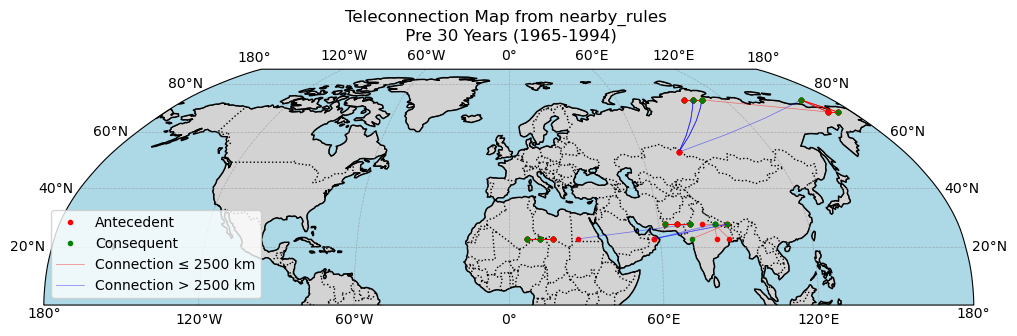

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

# haversine formula 計算球面距離 (單位: km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 地球半徑 km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))

# 1. 創建地圖
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# 繪製陸地、海洋、邊界
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

# 經緯網格線
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# 2. 繪製資料
first_ante, first_cons, first_long, first_short = True, True, True, True
for idx, row in rules.iterrows():
    ante_coords = row['ante_coords']  # list of tuples [(lat, lon), ...]
    cons_coords = row['cons_coords']  # list of tuples [(lat, lon), ...]

    if isinstance(ante_coords, list) and isinstance(cons_coords, list):
        for (lat1, lon1) in ante_coords:
            # Antecedent
            ax.plot(lon1, lat1, 'ro', markersize=3,
                    transform=ccrs.PlateCarree(),
                    label='Antecedent' if first_ante else "")
            first_ante = False

            for (lat2, lon2) in cons_coords:
                # Consequent
                ax.plot(lon2, lat2, 'go', markersize=3,
                        transform=ccrs.PlateCarree(),
                        label='Consequent' if first_cons else "")
                first_cons = False

                # 計算距離
                dist_km = haversine(lat1, lon1, lat2, lon2)
                if dist_km > 2500:
                    color = 'blue'
                    label = 'Connection > 2500 km' if first_long else ""
                    first_long = False
                else:
                    color = 'red'
                    label = 'Connection ≤ 2500 km' if first_short else ""
                    first_short = False

                ax.plot([lon1, lon2], [lat1, lat2],
                        color=color, linewidth=0.5, alpha=0.5,
                        transform=ccrs.PlateCarree(),
                        label=label)

plt.title('Teleconnection Map from nearby_rules \n Pre 30 Years (1965-1994)')
ax.legend(loc='lower left')

# 指定輸出資料夾
out_dir = "D:\\es\\association_rule"

# plt.savefig(
#     os.path.join(out_dir, 'pre30y(52.625, 77.375)_dis.png')
#     , dpi=300, bbox_inches='tight')
plt.show()
plt.close()

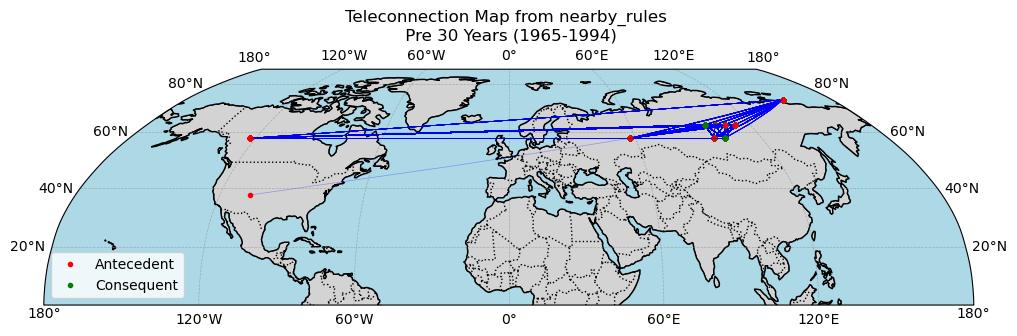

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# 1. 創建地圖
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# 標籤控制
ante_plotted = False
cons_plotted = False

nearby_rules = nearby_rules[:1000]

# 2. 迭代 nearby_rules 繪圖
for idx, row in nearby_rules.iterrows():
    ante_coords = row['ante_coords']
    cons_coords = row['cons_coords']
    
    if isinstance(ante_coords, list) and isinstance(cons_coords, list):
        for (lat1, lon1) in ante_coords:
            # 標記前事件座標
            label = 'Antecedent' if not ante_plotted else None
            ax.plot(lon1, lat1, 'ro', markersize=3, transform=ccrs.PlateCarree(), label=label)
            ante_plotted = True
            
            for (lat2, lon2) in cons_coords:
                # 標記後事件座標
                label = 'Consequent' if not cons_plotted else None
                ax.plot(lon2, lat2, 'go', markersize=3, transform=ccrs.PlateCarree(), label=label)
                cons_plotted = True
                
                # 繪製連線
                ax.plot([lon1, lon2], [lat1, lat2],
                        color='blue', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

# 顯示 legend，只會顯示一次
ax.legend(loc='lower left')
plt.title('Teleconnection Map from nearby_rules \n Pre 30 Years (1965-1994)')
# 指定輸出資料夾
out_dir = "D:\\es\\frequent_itemset"

# plt.savefig(
#     os.path.join(out_dir, 'pre30y(27.625, 82.375).png')
#     , dpi=300, bbox_inches='tight')
plt.show()

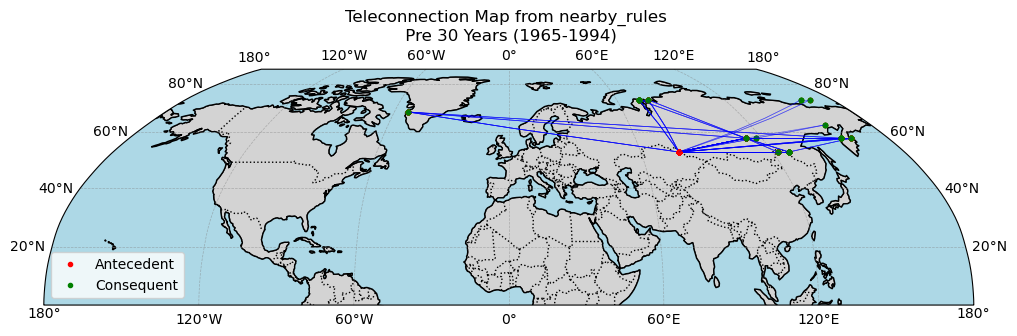

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# 1. 創建地圖
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# 標籤控制
ante_plotted = False
cons_plotted = False

# 2. 迭代 nearby_rules 繪圖
for idx, row in nearby_rules.iterrows():
    ante_coords = row['ante_coords']
    cons_coords = row['cons_coords']
    
    if isinstance(ante_coords, list) and isinstance(cons_coords, list):
        for (lat1, lon1) in ante_coords:
            # 標記前事件座標
            label = 'Antecedent' if not ante_plotted else None
            ax.plot(lon1, lat1, 'ro', markersize=3, transform=ccrs.PlateCarree(), label=label)
            ante_plotted = True
            
            for (lat2, lon2) in cons_coords:
                # 標記後事件座標
                label = 'Consequent' if not cons_plotted else None
                ax.plot(lon2, lat2, 'go', markersize=3, transform=ccrs.PlateCarree(), label=label)
                cons_plotted = True
                
                # 繪製連線
                ax.plot([lon1, lon2], [lat1, lat2],
                        color='blue', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

# 顯示 legend，只會顯示一次
ax.legend(loc='lower left')
plt.title('Teleconnection Map from nearby_rules \n Pre 30 Years (1965-1994)')
# 指定輸出資料夾
# out_dir = "D:\\es\\association_rule"

# plt.savefig(
#     os.path.join(out_dir, 'pre30y(52.625, 77.375).png')
#     , dpi=300, bbox_inches='tight')
plt.show()